# **Rebalancing**

### ***Loading Libraries***

In [21]:
# Operating Systems
import os
import shutil

# Numerical Computing
import numpy as np

# Data Manipuation
import pandas as pd

# SciPy
import scipy
from scipy import stats

# Data Visualization
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# BigQuery
from google.cloud import bigquery
from google.colab import auth

# Scikit-Learn
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer

# Extreme Gradient Boosting
import xgboost as xgb

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow_hub import KerasLayer
from tensorflow import feature_column as fc
from tensorflow.keras.preprocessing import text
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks, layers, models, utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Conv2D, MaxPooling2D

In [2]:
# User Authentication
auth.authenticate_user()

# BigQuery Library
# !pip install --upgrade google-cloud-bigquery

In [3]:
project_id = 'core-catalyst-425922-v9'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

# BigQuery Client Config
client = bigquery.Client(project=project_id)

### ***Downsampling***

In [4]:
# Data Downloading & Preview
!gsutil cp gs://ml-design-patterns/fraud_data_kaggle.csv .

Copying gs://ml-design-patterns/fraud_data_kaggle.csv...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

- [1 files][470.7 MiB/470.7 MiB]   21.6 MiB/s                                   
Operation completed over 1 objects/470.7 MiB.                                    


In [5]:
fraud_data = pd.read_csv('fraud_data_kaggle.csv')
fraud_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# Dropping few columns
fraud_data = fraud_data.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])
fraud_data = pd.get_dummies(fraud_data)

In [7]:
# Splitting DataFrames
fraud = fraud_data[fraud_data['isFraud'] == 1]
not_fraud = fraud_data[fraud_data['isFraud'] == 0]

not_fraud_sample = not_fraud.sample(random_state=2, frac=.005)

In [9]:
# Concatenating them back & Shuffling
fraud_data = pd.concat([not_fraud_sample,fraud])

fraud_data = shuffle(fraud_data, random_state=2)

In [10]:
# Looking Data Balance after Downsampling
fraud_data['isFraud'].value_counts()

isFraud
0    31772
1     8213
Name: count, dtype: int64

In [11]:
train_test_split = int(len(fraud_data) * .8)

train_data = fraud_data[:train_test_split]
test_data = fraud_data[train_test_split:]

train_labels = train_data.pop('isFraud')
test_labels = test_data.pop('isFraud')

In [14]:
model = xgb.XGBRegressor(
    objective='reg:linear'
)

In [15]:
model.fit(train_data.values, train_labels)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:12:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [16]:
# Getting Test Predictions
y_pred = model.predict(test_data.values)

In [17]:
# Setting Confusion Matrix
y_pred_formatted = []

for i in y_pred:
  y_pred_formatted.append(int(round(i)))

In [18]:
cm = confusion_matrix(test_labels.values, y_pred_formatted)
print(cm)

[[6375   28]
 [   9 1585]]


In [19]:
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

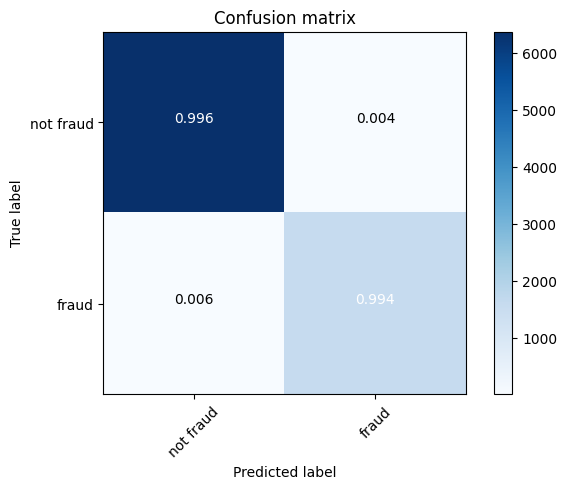

In [22]:
classes = ['not fraud', 'fraud']
plot_confusion_matrix(cm, classes, normalize=True)

### ***Weighted Classes & Output Bias***

In [27]:
%%bigquery --core-catalyst-425922-v9
SELECT
  *
FROM
  `bigquery-public-data.ml_datasets.ulb_fraud_detection`
WHERE Class = 1

In [ ]:
%%bigquery nonfraud_df --core-catalyst-425922-v9
SELECT
  *
FROM
  `bigquery-public-data.ml_datasets.ulb_fraud_detection`
WHERE Class = 0
AND RAND() < 0.05

In [ ]:
%%bigquery nonfraud_df --core-catalyst-425922-v9
SELECT
  *
FROM
  `bigquery-public-data.ml_datasets.ulb_fraud_detection`
WHERE Class = 0
AND RAND() < 0.05

In [ ]:
bq_fraud_data = pd.concat([fraud_df, nonfraud_df])
bq_fraud_data.sort_values(by=['Time'])

In [ ]:
# Scale Time & Amount Values
time_scaler = MinMaxScaler()
amt_scaler = MinMaxScaler()

bq_fraud_data['Time'] = time_scaler.fit_transform(bq_fraud_data['Time'].values.reshape(-1,1))
bq_fraud_data['Amount'] = amt_scaler.fit_transform(bq_fraud_data['Amount'].values.reshape(-1,1))

In [ ]:
bq_fraud_data['Class'].value_counts()

In [ ]:
train_test_split = int(len(bq_fraud_data) * .8)

train_data = bq_fraud_data[:train_test_split]
test_data = bq_fraud_data[train_test_split:]

train_labels = train_data.pop('Class')
test_labels = test_data.pop('Class')

In [ ]:
# Create a TF Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data.values, train_labels))
train_dataset = train_dataset.shuffle(len(train_data)).batch(1024)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data.values, test_labels))
test_dataset = test_dataset.shuffle(len(test_data)).batch(1)

In [ ]:
num_minority = train_labels.value_counts()[1]

num_majority = train_labels.value_counts()[0]

In [ ]:
minority_class_weight = 1 / (num_minority / len(train_data)) / 2

majority_class_weight = 1 / (num_majority / len(train_data)) / 2

keras_class_weights = {0: majority_class_weight, 1: minority_class_weight}
print(keras_class_weights)

# Retrieving Output Bias
output_bias = math.log(num_minority / num_majority)
print(output_bias)

In [ ]:
fraud_model = keras.Sequential([
    keras.layers.Dense(16, input_shape=(len(train_data.iloc[0]),), activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(output_bias))
])

In [ ]:
metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='roc_auc'),
]

In [ ]:
fraud_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

In [ ]:
fraud_model.fit(train_dataset, validation_data=test_dataset, epochs=10, class_weight=keras_class_weights)

#### ***Reframing: using cluster distance as a prediction signal***

In [ ]:
%%bigquery --core-catalyst-425922-v9
CREATE OR REPLACE MODEL
  `core-catalyst-425922-v9` OPTIONS(model_type='kmeans',
    num_clusters=4) AS
SELECT
  weight_pounds,
  mother_age,
  gestation_weeks
FROM
  `bigquery-public-data.samples.natality`
LIMIT 10000

In [ ]:
%%bigquery average_pred --core-catalyst-425922-v9
SELECT
  *
FROM
  ML.PREDICT (MODEL `core-catalyst-425922-v9`,
    (
    SELECT
      7.0 as weight_pounds,
      28 as mother_age,
      40 as gestation_weeks
     )
  )

In [ ]:
average_pred

In [ ]:
df['NEAREST_CENTROIDS_DISTANCE'].iloc[0]

In [ ]:
%%bigquery outlier_pred --core-catalyst-425922-v9
SELECT
  *
FROM
  ML.PREDICT (MODEL `core-catalyst-425922-v9`,
    (
    SELECT
      3.0 as weight_pounds,
      20 as mother_age,
      27 as gestation_weeks
     )
  )

In [ ]:
outlier_pred

In [ ]:
outlier_pred['NEAREST_CENTROIDS_DISTANCE'].iloc[0]